# Sidekick - Multi-Pojects Predictions

#### Model
Hence, our next idea is to consider $P$ projects at the same time and try to learn the hyperparameters $\theta$ over various time series. For a given project $p$, we have the following dataset $\mathcal{D}^{(p)} = \left\{ (x_i^{(p)}, y_i^{(p)}) \mid i = 1, ..., T \right\}$. Note that we have $x_i^{(p)}= x_i = i$. We combine the projects together to obtain a new dataset $\mathcal{D} = \left\{ \mathcal{D}^{(p)} \mid p = 1, ..., P \right\}$ (*multi-task learning*). We then have $X = [1, ..., T]^T$ an $(T \times 1)$ matrix of time indices and $Y = \left[\mathbf{y}^{(p)} \right]_{p=1}^P$ an $(T \times P)$ matrix of observed values per project. For a given project $p$, we are trying to predict the pledged money $\mathbf{f}_*  \equiv \mathbf{f}_*^{(p)} = \mathbf{f}_{t:T}^{(p)} = f(X_{t:T}^{(p)})$ at future time indices $X_*  \equiv X_*^{(p)} = X_{t:T}^{(p)} = X_{t:T} = [t,...,T]^T$ after observing the values $\mathbf{y}  \equiv \mathbf{y}^{(p)} = \mathbf{y}_{1:t}^{(p)}$ at time indices $X  \equiv X_{1:t} = [1, ..., t]^T$. To do so in the GP framework, we have

$$\mathbf{f}_* \mid X, \mathbf{y}, X_* \equiv \mathbf{f}_{t:T}^{(p)} \mid X_{1:t}, \mathbf{y}_{1:t}^{(p)}, X_{t:T} \sim \mathcal{N} \left( \overline{\mathbf{f}}_{t:T}^{(p)}, \text{ cov}(\mathbf{f}_{t:T}^{(p)}) \right), $$

with $\overline{\mathbf{f}}_{t:T}^{(p)} \equiv \overline{\mathbf{f}}_*$ as before and $\text{ cov}(\mathbf{f}_{t:T}^{(p)}) \equiv \text{ cov}(\mathbf{f}_*)$. The hyperparameters $\mathbf{\theta}$ of the GP are learned by maximizing the log marginal likelihood over all the projects, that is

$$\theta_* = \underset{\theta} {\arg\max} \sum_{p=1}^P \log p(\mathbf{y}^{(p)} \mid X, \theta).$$

#### Results
Again, we couldn't obtain good results with this approach, as the predictions always fall back very quickly to the mean of the GP. **[MORE DETAILS]**



In [60]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import pickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick
from model.utils.progressbar import ProgressBar

DATA_DIR = "../data/kickstarter-etter-cosn2013"

## Load data

In [2]:
sk = Sidekick()
sk.load()

Loading data set...
Data loaded.


## Prepare data
Keep `T`% of the projects for training and `(100-T)`% for testing.

In [89]:
N = 1000
projects = sk.data[:N]
num_observations = 1000
T = 0.7

threshold = int(floor(T * len(projects)))
projects_train = projects[:threshold]
projects_test = projects[threshold:]
X_train = np.ndarray(shape=(num_observations, 1), buffer=np.arange(num_observations), dtype=int)
Y_train = np.array([project.money for project in projects]).T
print(X_train.shape, Y_train.shape)

(1000, 1) (1000, 1000)


## Train model
Train a GP with a given kernel.

In [90]:
kernel = GPy.kern.RBF(input_dim=1, lengthscale=500) + GPy.kern.RBF(input_dim=1)
m = GPy.models.GPRegression(X_train, Y_train, kernel)
#m.optimize_restarts(num_restarts=10)
m.optimize()
display(m)

GP_regression.,value,constraints,priors
sum.rbf.variance,4.9663924714,+ve,
sum.rbf.lengthscale,106.42275565,+ve,
sum.rbf_1.variance,0.0098527356891,+ve,
sum.rbf_1.lengthscale,4.65232640355,+ve,
Gaussian_noise.variance,0.00083244580138,+ve,


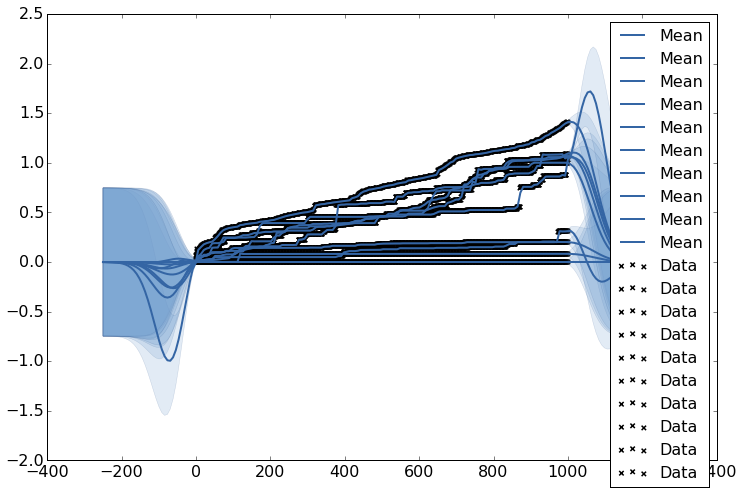

In [34]:
m.plot()

## Test unseen project
We observe 80% of the project pledged money and we predict then the last point, that is the total amount of money pledged at the end of the project. If it is greater than 1, then the project has been funded.

In [82]:
new_project = projects_test[20]
print(new_project)
proportion = 0.7
last_observation = 999

goal = new_project.goal
observe = int(floor(num_observations * proportion))

X_observation = np.ndarray(shape=(observe, 1), buffer=np.arange(observe), dtype=int) 
Y_observation = np.ndarray(shape=(observe, 1), buffer=np.array([m for m in new_project.money[:observe]]), dtype=float) 
m.set_XY(X=X_observation, Y=Y_observation)
mean, var = m.predict(np.ndarray((1,1), buffer=np.array(last_observation), dtype=int))
predicted_pledged = mean[0][0]
predicted_var = var[0][0]
actual_pledged = new_project.money[last_observation]
print("Goal: %s" % goal)
print("Predicted success: %s (%.2f±%.2f)" % (str(predicted_pledged > 1), predicted_pledged, np.sqrt(predicted_var)))
print("Actual success: %s (%.2f)" % (str(actual_pledged > 1), actual_pledged))

Project 1394790042 is failed
Goal: 7500
Predicted success: False (-0.00±8.05)
Actual success: False (0.32)


## Evaluation
Run an evaluation on the full test set.

In [91]:
def evaluate_project(project):
    last_observation = 999
    goal = project.goal
    correct = []
    for p in np.linspace(0.01, 0.99, 20):
        # Set the number of observed data
        observe = int(floor(num_observations * p))
        # Set the new observation in the model without modifying it
        X_observation = np.ndarray(shape=(observe, 1), buffer=np.arange(observe), dtype=int) 
        Y_observation = np.ndarray(shape=(observe, 1), buffer=np.array([m for m in new_project.money[:observe]]), dtype=float) 
        m.set_XY(X=X_observation, Y=Y_observation)
        # Predict the end of the project
        mean, var = m.predict(np.ndarray((1,1), buffer=np.array(last_observation), dtype=int))
        predicted_pledged = mean[0][0]
        predicted_success = predicted_pledged >= 1
        predicted_var = var[0][0]
        actual_pledged = project.money[last_observation]
        actual_success = actual_pledged >= 1
        correct.append(predicted_success == actual_success)
    return correct

result = []
total = len(projects_test)
bar = ProgressBar(total, count=True, text="Projects")
bar.start()
for i, project in enumerate(projects_test):
    result.append(evaluate_project(project))
    bar.update(i)

Projects (300/300): [####################] 100% Elapsed time: 0:13:52


In [ ]:
print(result)

## Plot result
Plot the accuracy versus relative time together with error bars.

[ 0.49333333  0.49333333  0.49333333  0.49333333  0.49333333  0.49333333
  0.49333333  0.49333333  0.49333333  0.49333333  0.49333333  0.49333333
  0.49333333  0.49333333  0.49333333  0.49333333  0.49333333  0.49333333
  0.49333333  0.49333333]


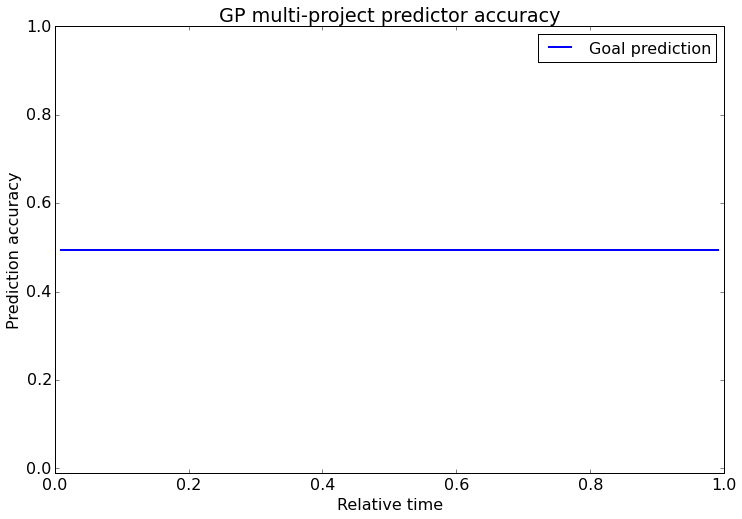

In [93]:
r = np.array(result)
print(np.mean(r, axis=0))
plt.plot(np.linspace(0.01, 0.99, 20), np.mean(r, axis=0), lw=2, label="Goal prediction")
plt.title("GP multi-project predictor accuracy")
plt.ylabel("Prediction accuracy")
plt.xlabel("Relative time")
plt.legend()
plt.ylim([-0.01, 1])
plt.savefig("multiproject_prediction.pdf")
plt.show()